In [234]:
from mindspore import context

context.set_context(mode=context.GRAPH_MODE, device_target="CPU")

In [235]:
import numpy as np

#### get_data生成的数据用于传入model,打包完解压形状为（16，2)与Dense对应
#打包的x**2，x对应W1,W2

In [236]:
def get_data(num, w1=2, w2=-3, b=-2):
    for i in range(num):
        x = np.random.uniform(-20, 20)
        noise = np.random.normal(0, 1)
        y = w1 * x * x + w2 * x + b + noise
        yield np.array([x**2,x]).astype(np.float32),np.array([y]).astype(np.float32)

### for_plot_data函数生成的数据用画图，所以只打包了X

In [237]:
def for_plot_data(num, w1=2, w2=-3, b=-2):
    for i in range(num):
        x=np.random.uniform(-20,20)
        noise=np.random.normal(0,1)
        y = w1 * x * x + w2 * x + b + noise
        yield np.array([x]).astype(np.float32),np.array([y]).astype(np.float32)

### 绘制图像

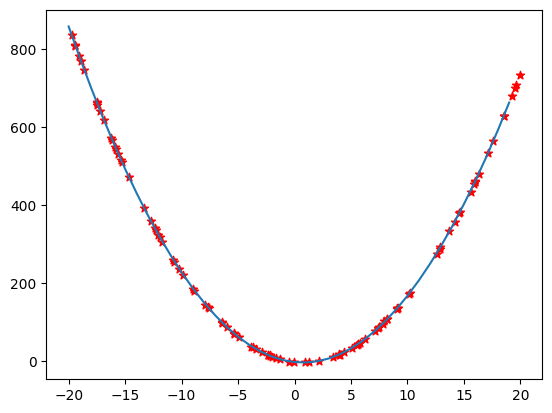

In [238]:
from matplotlib import pyplot as plt
eval_data = list(for_plot_data(100))
x_eval, y_eval = zip(*eval_data)
x_real = np.arange(-20, 20)
y_real = 2 * x_real * x_real - 3 * x_real - 2
fig=plt.figure()
# plt.axes([-20,20,0,800])
plt.plot(x_real,y_real)
plt.scatter(x_eval,y_eval,c="red",marker='*')

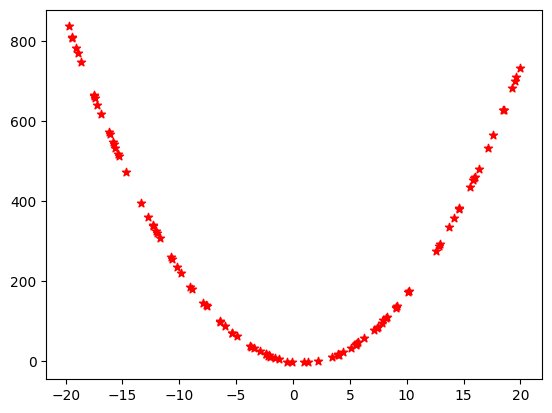

In [239]:
plt.scatter(x_eval,y_eval,c="red",marker='*')

### GeneratorDataset函数的初次使用，生成训练集

In [240]:
from mindspore import dataset as ds


def crate_dateset(num, batch_size, repeat_size):
    input_data = ds.GeneratorDataset(list(get_data(num)),
                                     column_names=['data', 'label'])
    input_data = input_data.batch(batch_size)
    input_data = input_data.repeat(repeat_size)
    return input_data

In [241]:
# 因为打包了x**2和x所以这里x的形状是(16,2)

In [242]:
batch_size=16
num=1600
repeat_size=1
ds_train=crate_dateset(num,batch_size,repeat_size)
dict_datasets = next(ds_train.create_dict_iterator())
print("训练集大小:===>>>",ds_train.get_dataset_size())
print("The x label value shape:", dict_datasets["data"].shape)

[WARNING] ME(13420:3128,MainProcess):2022-11-11-21:13:06.257.925 [mindspore\dataset\engine\datasets_user_defined.py:657] Python multiprocessing is not supported on Windows platform.


训练集大小:===>>> 100
The x label value shape: (16, 2)


### 多次项网络

In [243]:
import mindspore.nn as nn
from  mindspore.common.initializer import Normal 
class MulLineNet(nn.Cell):
    def __init__(self):
        super(MulLineNet,self).__init__()
        self.fc=nn.Dense(2,1,Normal(0,1),Normal(0,1))
    def construct(self,x):
        x=self.fc(x)
        return x
        

In [244]:
net =MulLineNet()
print(net)

MulLineNet<
  (fc): Dense<input_channels=2, output_channels=1, has_bias=True>
  >


### trainable_params()将网络的权重参数取出，并用于绘图

In [245]:
from mindspore import Tensor
import time
def plot_data(net,eval_data):
    weight=net.trainable_params()[0]
    bias=net.trainable_params()[1]
    for temp_parm in net.trainable_params():
        print("-----######-----",temp_parm.asnumpy)
    x=np.arange(-20,20)
    y = x*x*Tensor(weight).asnumpy()[0][0] +x * Tensor(weight).asnumpy()[0][1]+ Tensor(bias).asnumpy()[0]
    x_eval,y_eval=zip(*eval_data)
    x_real=x
    y_real=2*x_real*x_real-3*x_real-2
    plt.scatter(x_eval,y_eval,c='r',marker='*')
#     plt.plot(x,y,c='c')
    plt.plot(x_real,y_real,c='b')
    plt.show()
    time.sleep(0.5)

In [246]:
#使用callback回调机制实时动态绘图

In [247]:

from IPython import display
from mindspore.train.callback import Callback

class ImageShowCallback(Callback):
    def __init__(self, net, eval_data):
        self.net = net
        self.eval_data = eval_data

    def step_end(self, run_context):
        plot_data(self.net, self.eval_data)
        display.clear_output(wait=True)


### 初始化网络开始训练，拟合

In [248]:
#定义损失函数和优化器
import mindspore.nn as nn
net_loss=nn.loss.MSELoss()

net_opt=nn.Momentum(net.trainable_params(),learning_rate=0.005,momentum=0.9)


<class 'tuple'>
<class 'tuple'>
100
100


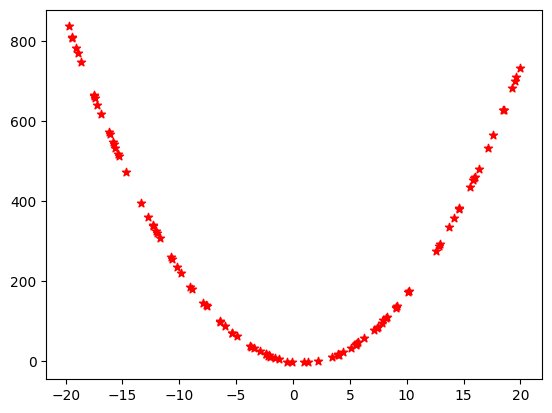

In [249]:
print(type(x_eval))
print(type(y_eval))
print(len(x_eval))
print(len(y_eval))
plt.scatter(x_eval,y_eval,c="red",marker='*')

In [250]:
from mindspore import Model
from mindspore.train.callback import LossMonitor
image_show_cb=ImageShowCallback(net,eval_data)
# ds_train2=crate_dateset(100,10,1)
model=Model(net,loss_fn=net_loss,optimizer=net_opt)
model.train(epoch=1,train_dataset=ds_train,callbacks=LossMonitor(10))
params=net.trainable_params()
for param in params:
    print(param)
    print(param.asnumpy())



ValueError: In epoch: 1 step: 8, loss is NAN or INF, training process cannot continue, terminating training.